# Short Bursts Distributions

We look at short bursts on PA and AR senate.

In [230]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.tree import recursive_tree_part
from gerrychain.metrics import mean_median, efficiency_gap, polsby_popper, partisan_gini
from functools import (partial, reduce)
import pandas
import geopandas as gp
import numpy as np
import networkx as nx
import pickle
import seaborn as sns
import pprint
import operator
import scipy
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize
import random
from nltk.util import bigrams
from nltk.probability import FreqDist
from gingleator import Gingleator
from numpy.random import randn
from scipy.stats import norm, probplot

In [2]:
## This function takes a name of a shapefile and returns a tuple of the graph
## and its associated dataframe
def build_graph(filename):
    print("Pulling in Graph from Shapefile: " + filename)
    graph = Graph.from_file(filename)
    df = gp.read_file(filename)
    return(graph, df)

In [10]:
## Set up PA enacted
graph_PA = pickle.load(open("PA_graph.p", "rb"))
df_PA = pickle.load(open("PA_df.p", "rb"))

PA_updaters = {"population": updaters.Tally("TOT_POP", alias="population"),
               "bvap": updaters.Tally("BLACK_POP", alias="bvap"),
               "vap": updaters.Tally("VAP", alias="vap"),
               "bvap_prec": lambda part: {k: part["bvap"][k] / part["population"][k] for k in part["bvap"]}}

PA_enacted_senate = GeographicPartition(graph_PA, assignment="SSD", 
                                     updaters=PA_updaters)

In [4]:
total_population_PA = sum(df_PA.TOT_POP.values)
ideal_population_PA = total_population_PA / 50

In [5]:
seed_part_senate = recursive_tree_part(graph_PA, range(50), pop_col="TOT_POP",
                                pop_target=ideal_population_PA,
                                epsilon=0.01, node_repeats=1)
PA_seed_seante = GeographicPartition(graph_PA, assignment=seed_part_senate,updaters=PA_updaters)

In [6]:
## Set up AR
graph_AR = pickle.load(open("graph_AR.p", "rb"))
df_AR = pickle.load(open("df_AR.p", "rb"))

AR_updaters = {"population": updaters.Tally("TOTPOP", alias="population"),
               "bvap": updaters.Tally("BVAP", alias="bvap"),
               "vap": updaters.Tally("VAP", alias="vap"),
               "bvap_prec": lambda part: {k: part["bvap"][k] / part["vap"][k]
                                          for k in part["bvap"]}}

AR_enacted_senate = GeographicPartition(graph_AR, assignment="SSD", updaters=AR_updaters)

Pulling in Graph from Shapefile: AR_shape/AR.shp


In [7]:
total_population_AR = sum(df_AR.TOTPOP.values)
ideal_population_AR = total_population_AR / 35

In [8]:
senate_seed = recursive_tree_part(graph_AR, range(35), pop_col="TOTPOP",
                                pop_target=ideal_population_AR,
                                epsilon=0.01, node_repeats=1)
AR_seed_senate = GeographicPartition(graph_AR, assignment=senate_seed,updaters=AR_updaters)

In [221]:
house_seed = recursive_tree_part(graph_AR, range(100),
                                  pop_col="TOTPOP",
                                  pop_target=total_population_AR / 100,
                                  epsilon=0.01, node_repeats=1)
AR_seed_house = GeographicPartition(graph_AR, assignment=house_seed,
                                    updaters=AR_updaters)

KeyboardInterrupt: 

In [14]:
Gingleator.num_opportunity_dists(PA_enacted_senate, "bvap_prec", 0.4)

4

In [15]:
Gingleator.num_opportunity_dists(PA_seed_seante, "bvap_prec", 0.4)

3

In [16]:
Gingleator.num_opportunity_dists(AR_seed_senate, "bvap_prec", 0.4)

3

## Reprojections onto the line

In [33]:
def transition_frequencies(observations):
    observations = observations.astype(int)
    dim = observations.max()
    
    seen_bigrams = []
    for row in observations:
        seen_bigrams.extend(bigrams(row))
    fdist = FreqDist(seen_bigrams)
    
    probs = np.zeros((dim, dim))
    for k, v in fdist.items():
        probs[k[0]-1][k[1]-1] = v
    probs = normalize(probs, norm="l1")
    return probs

In [34]:
def rand_walk_graph(transition_frequencies):
    G = nx.from_numpy_array(transition_frequencies, create_using=nx.DiGraph)
    mapping = {n: n+1 for n in G.nodes}
    G = nx.relabel_nodes(G, mapping)
    return G

In [177]:
def edge_weights(G, prec=None):
    if not prec:
        return dict([((u,v,), d['weight']) for u,v,d in G.edges(data=True)])
    else:
        return dict([((u,v,), round(d['weight'],prec)) for u,v,d in G.edges(data=True)])

In [75]:
PA_gingles = Gingleator(PA_seed_seante, pop_col="TOT_POP", minority_prec_col="bvap_prec",
                        epsilon=0.1)

In [76]:
AR_gingles = Gingleator(AR_seed_senate, pop_col="TOTPOP", minority_prec_col="bvap_prec",
                        epsilon=0.1)

#### PA random walk graph

In [78]:
_, PA_observations = PA_gingles.short_burst_run(num_bursts=200, num_steps=25)

In [90]:
PA_trans = transition_frequencies(PA_observations)

In [91]:
PA_rand_walk = rand_walk_graph(PA_trans)

In [48]:
edge_weights(PA_rand_walk)

{(3, 3): 0.9945,
 (3, 4): 0.0055,
 (4, 3): 0.0299,
 (4, 4): 0.9669,
 (4, 5): 0.0032,
 (5, 4): 0.0641,
 (5, 5): 0.9359}

#### AR random walk graph

In [79]:
_, AR_observations = AR_gingles.short_burst_run(num_bursts=200, num_steps=25)

In [202]:
AR_trans = transition_frequencies(AR_observations)

In [203]:
AR_rand_walk = rand_walk_graph(AR_trans)

In [204]:
edge_weights(AR_rand_walk)

{(1, 1): 0.9,
 (1, 2): 0.1,
 (2, 1): 0.038461538461538464,
 (2, 2): 0.8846153846153846,
 (2, 3): 0.07692307692307693,
 (3, 2): 0.010687022900763359,
 (3, 3): 0.9450381679389313,
 (3, 4): 0.044274809160305344,
 (4, 3): 0.037241379310344824,
 (4, 4): 0.952183908045977,
 (4, 5): 0.010574712643678161,
 (5, 4): 0.08376421923474664,
 (5, 5): 0.9162357807652534}

## Distribution of Observations

In [182]:
def stationary_distribution(graph):
    probs = edge_weights(graph)
    observed_nodes = reduce(lambda s, k: s | set(k), probs.keys(), set())
    observed_nodes.remove(min(observed_nodes))
    stationary = reduce(lambda pis, i: pis + [pis[-1]*probs[i-1, i] / probs[i, i-1]], observed_nodes, [1])
    stationary = normalize([stationary], norm="l1")
    return stationary[0]

In [85]:
_, PA_unbiased_run = PA_gingles.short_burst_run(num_bursts=1, num_steps=5000)
# _, PA_burst_run = PA_gingles.short_burst_run(num_bursts=100, num_steps=10)

In [186]:
stationary = stationary_distribution(PA_rand_walk)
stat = np.random.choice([3,4,5], 5000, p=stationary)

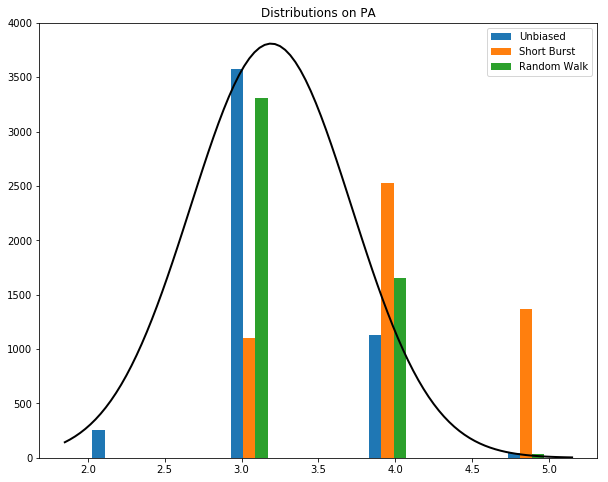

In [251]:
mu, std = norm.fit(PA_unbiased_run.flatten())

plt.figure(figsize=(10,8))
plt.title("Distributions on PA")
plt.hist([PA_unbiased_run.flatten(), PA_observations.flatten(),stat],
         label=["Unbiased","Short Burst","Random Walk"])
p = norm.pdf(x, mu, std)
plt.plot(x, p*5000, 'k', linewidth=2)
plt.legend()
plt.show()

In [199]:
_, AR_unbiased_run = AR_gingles.short_burst_run(num_bursts=1, num_steps=5000)

In [207]:
AR_stationary = stationary_distribution(AR_rand_walk)
AR_stat = np.random.choice([1,2,3,4,5], 5000, p=AR_stationary)

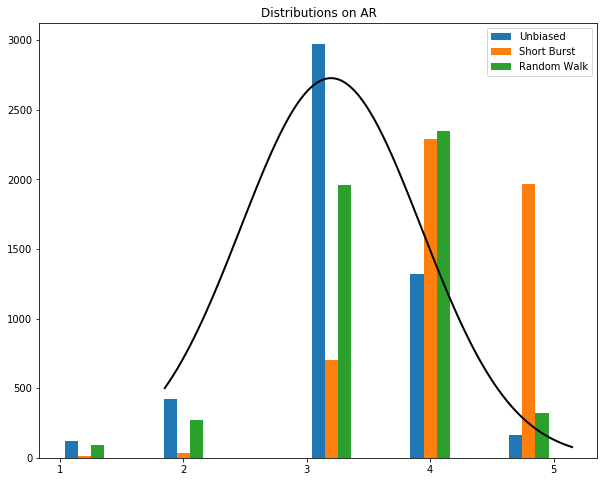

In [252]:
mu, std = norm.fit(AR_unbiased_run.flatten())
plt.figure(figsize=(10,8))
plt.title("Distributions on AR")
plt.hist([AR_unbiased_run.flatten(), AR_observations.flatten(), AR_stat],
         label=["Unbiased","Short Burst","Random Walk"])
p = norm.pdf(x, mu, std)
plt.plot(x, p*5000, 'k', linewidth=2)
plt.legend()
plt.show()

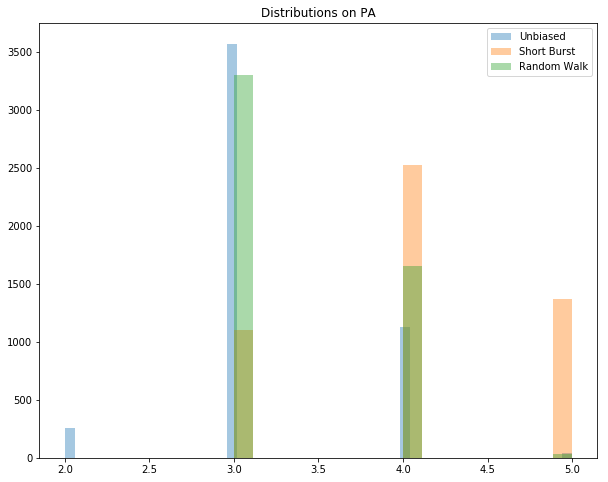

In [218]:
plt.figure(figsize=(10,8))
plt.title("Distributions on PA")
sns.distplot(PA_unbiased_run.flatten(), kde=False, label="Unbiased")
sns.distplot(PA_observations.flatten(), kde=False, label="Short Burst")
sns.distplot(stat, kde=False, label="Random Walk")
plt.legend()
plt.show()

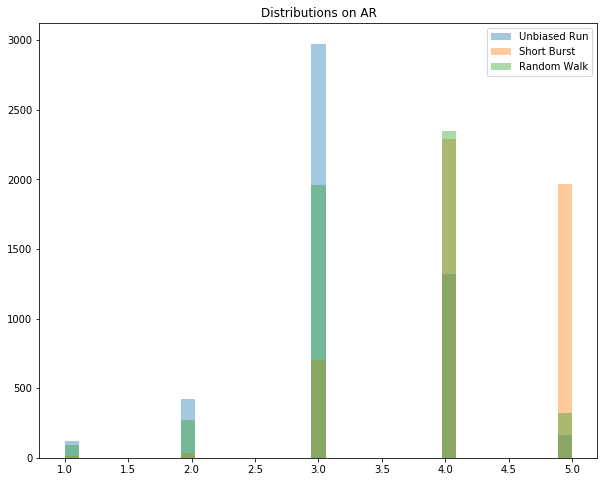

In [213]:
plt.figure(figsize=(10,8))
plt.title("Distributions on AR")
sns.distplot(AR_unbiased_run.flatten(), kde=False, label="Unbiased Run")
sns.distplot(AR_observations.flatten(), kde=False, label="Short Burst")
sns.distplot(AR_stat, kde=False, label="Random Walk")
plt.legend()
plt.show()

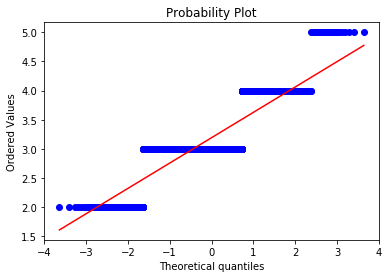

In [238]:
plt.figure()
probplot(PA_unbiased_run.flatten(), plot=plt)
plt.show()

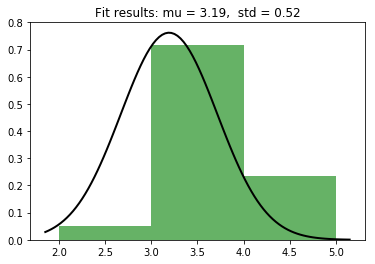

In [245]:
mu, std = norm.fit(PA_unbiased_run.flatten())
plt.hist(PA_unbiased_run.flatten(), bins=3, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [228]:
PA_observations[100]

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 4.])

In [254]:
dist_precs = enacted_senate["bvap_prec"].values()

In [257]:
sum(list(map(lambda v: v >= 0.4, dist_precs)))

4

In [259]:
max(i for i in dist_precs if i < 0.4) 

0.23961893169795423